In [96]:
import sys
print(sys.version)

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]


In [97]:
#OPTIONAL! LOAD
import pickle
with open(f'drive/MyDrive/DATA/COMBINED-2023-05-28 21:19:09.738396-Combined.pkl', 'rb') as inp:
    trials  = pickle.load(inp)

#trials

# Part 0

In [98]:
# eps = (0.1, 10.0)
# neps = len(eps)
# K = 2
synthesizer_count=3

x = (0,3,6,12)
das_score_cols = ['das28_remission_m0','das28_remission_m3','das28_remission_m6','das28_remission_m12']


eps = (0.05, 0.1, 0.2, 0.5, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0) # removed 10.0
#eps = (0.05, 0.1, 0.2, 0.5, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 10.0)
#eps = (0.05, 0.1, 0.2, 0.5, 1.0, 1.25, 1.5, 2.0, 3.5, 4.0)
neps = len(eps)
K = 20

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

data_csv_path = 'drive/MyDrive/DATA/MTX_NAs_Dropped_v2.csv'
dat = pd.read_csv(data_csv_path,sep=' ') # in datasets/
dat_sub = dat[das_score_cols]
y1 = list(dat_sub.mean())


In [100]:
import numpy as np
from scipy.spatial import distance
from scipy.stats import pearsonr

In [101]:
def plot_remission_curves(
    title="", xlabel="", ylabel="",
    Y=[],
    ax_bottom_limit=-1e-3,
    ax_top_limit=1.0,
    plot_original_curve=True,
    label = 'Synthetic Data',
    secondary_color = 'orange',
    show_grid=False
    ):
  """
  returns ax

  title                String, Plot Title.
  xlabel               String, Plot X Label.
  ylabel               String, Plot Y Label.
  Y                    Array-like, Y to plot.
  ax_bottom_limit      Float, bottom of axis.
  ax_top_limit         Float, top of axis. 
  plot_original_curve  Boolean, plot original remission curve.
  """

  # FRAME AND AESTHETICS
  plt.figure(figsize=(6, 6))
  ax = plt.gca()
  ax.set_ylim(bottom=ax_bottom_limit, top=ax_top_limit)
  if show_grid:
    ax.grid()

  # TITLE AND LABELS
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

  # ORIGINAL DATA
  plt.xticks(x, x)
  if plot_original_curve:
    plt.plot(x,y1,'v',linestyle='dashed',label='Original Data')

  # ADDITIONAL DATA
  if len(Y) != 0:
    plt.plot(x,Y,'*',linestyle='dashed',color=secondary_color,label=label)

  return ax

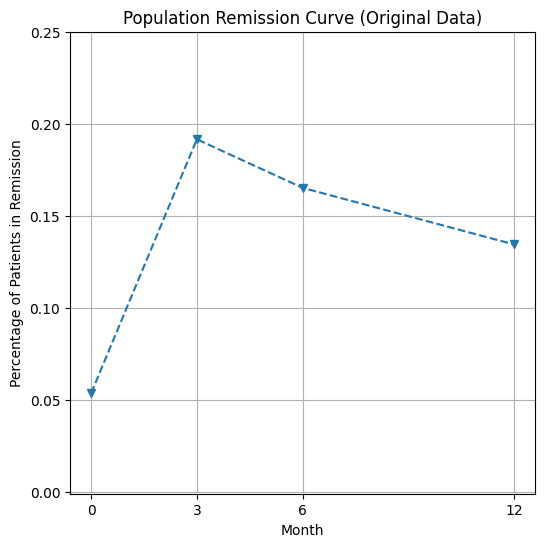

In [102]:
ax = plot_remission_curves(
    title="Population Remission Curve (Original Data)",
    xlabel="Month",
    ylabel="Percentage of Patients in Remission",
    ax_top_limit = 0.25,
    show_grid=True
    )

In [103]:
# Recompute y1 for m/f

dat_m = dat[dat['sex']=='male'][das_score_cols]
dat_f = dat[dat['sex']=='female'][das_score_cols]
y1_m = list(dat_m.mean())
y1_f = list(dat_f.mean())


len(dat_m), len(dat_f)

(328, 810)

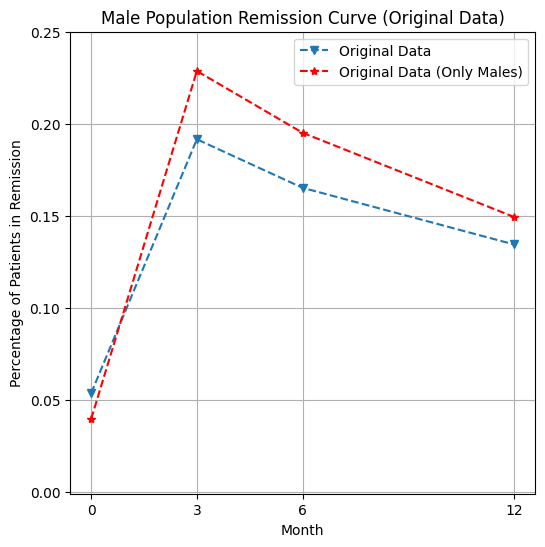

In [104]:
ax = plot_remission_curves(
    Y = y1_m, label = 'Original Data (Only Males)',
    title="Male Population Remission Curve (Original Data)",
    xlabel="Month",
    ylabel="Percentage of Patients in Remission",
    ax_top_limit = 0.25,
    secondary_color='red',
    show_grid=True
    )

plt.legend()

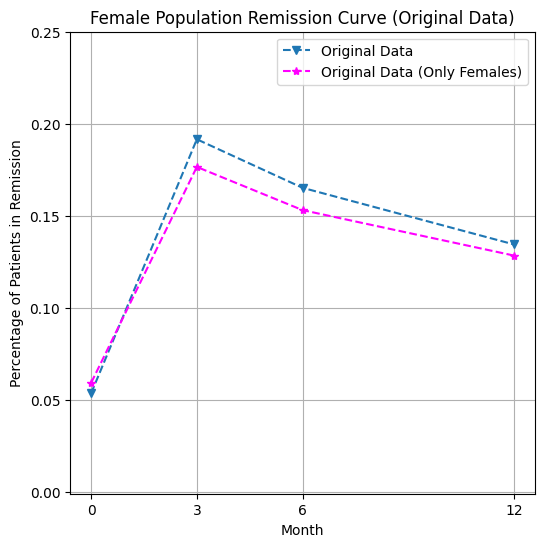

In [105]:
ax = plot_remission_curves(
    Y = y1_f, label = 'Original Data (Only Females)',
    title="Female Population Remission Curve (Original Data)",
    xlabel="Month",
    ylabel="Percentage of Patients in Remission",
    ax_top_limit = 0.25,
    secondary_color='magenta',
    show_grid=True
    )

plt.legend()

In [106]:
print(np.around(y1_m,4) * 100) 
print(np.around(y1_f,4) * 100) 

[ 3.96 22.87 19.51 14.94]
[ 5.93 17.65 15.31 12.84]


# Part 1

### Normalized Pairwise Jenson-Shannon Distance

In [107]:
def jensen_shannon_distances(A,B):
  res = [distance.jensenshannon([a,1-a],[b,1-b]) for a,b in zip(A, B)]
  #print(res)
  return res

#### Single Computation

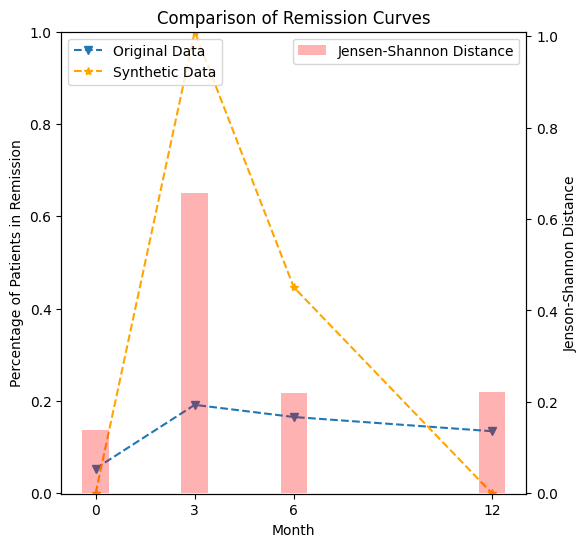

In [108]:
sample_dat = trials[0][0][0]
sample_dat_sub = sample_dat[das_score_cols]
Y = list(sample_dat_sub.mean())


ax = plot_remission_curves(
    title="Comparison of Remission Curves", xlabel="Month", ylabel="Percentage of Patients in Remission",
    Y=Y,
    ax_bottom_limit=-1e-3,
    ax_top_limit=1.0,
    plot_original_curve=True
    )
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.set_ylabel('Jenson-Shannon Distance')
ax2.set_ylim(bottom=-1e-3, top=1.0+1e-2)

distances = jensen_shannon_distances(y1,Y)
ax2.bar( x,distances, color=(1.0, 0, 0, 0.3), label='Jensen-Shannon Distance'  )
ax2.legend(loc='upper right')

In [109]:
print(np.around(y1,4))
print(np.around(Y,4))
print(np.around(distances,4))

[0.0536 0.1916 0.1652 0.1344]
[0.     1.     0.4464 0.    ]
[0.1376 0.6561 0.2189 0.2214]


#### Plot

In [110]:
trial_performances = np.zeros((neps, synthesizer_count))
rates = np.zeros((neps, synthesizer_count, K, len(x)))

trial_measures = np.zeros((neps, synthesizer_count, K))
trial_err = np.zeros((neps, synthesizer_count, 2))

for i in range(neps):
  for j in range(synthesizer_count):
    for k in range(K):
      t = trials[i][j][k]
      rates[i][j][k] = list(t[das_score_cols].mean())
      y2 = rates[i][j][k]
      distances = jensen_shannon_distances(y1,y2)
      #print(i,j,k, distances)
      #trial_performances[i][j] += np.mean(distances) #Normalize by length of 4, since we have 4 windows (0,3,6,12)
      trial_measures[i][j][k] = np.mean(distances) #Normalize by length of 4, since we have 4 windows (0,3,6,12)
    #trial_performances[i][j] /= K
    trial_performances[i][j] = np.median(trial_measures[i][j])
    #print(np.percentile( trial_measures[i][j], [75,25] ) )
    trial_err[i][j] = [trial_performances[i,j] , -trial_performances[i,j]] + [-1,1] * np.percentile( trial_measures[i,j], [25,75] )

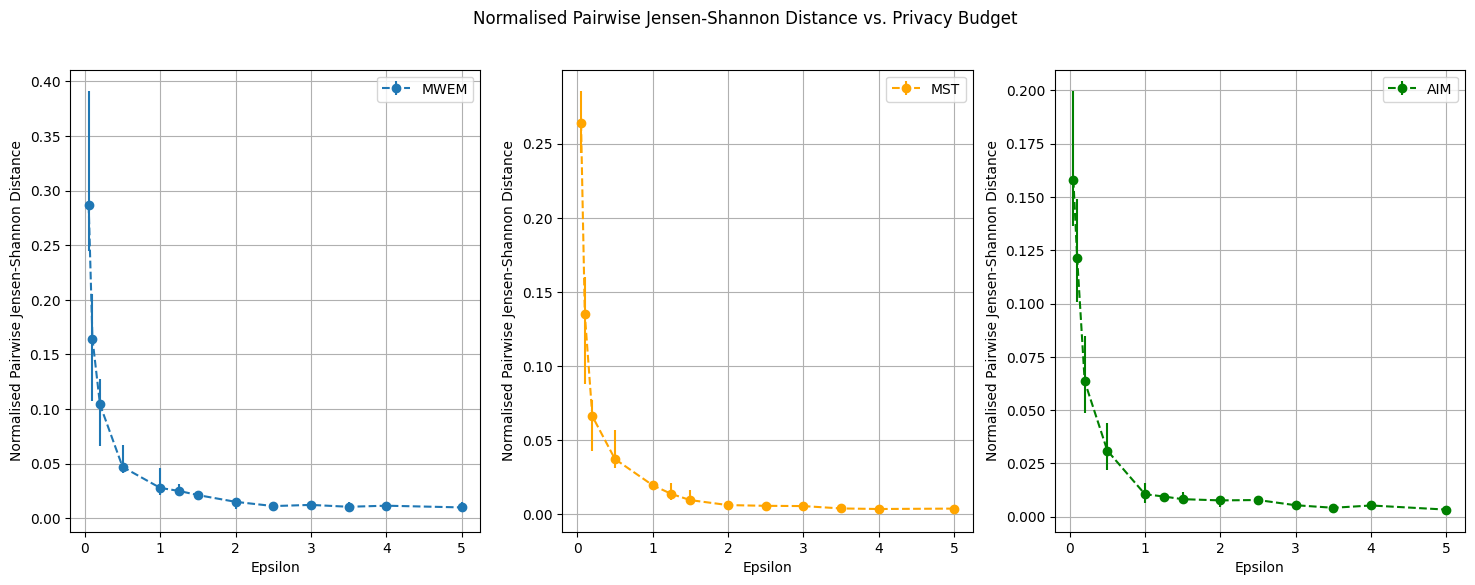

In [111]:
fig = plt.figure(figsize=(18, 6))
# plt.title("Mean Jensen-Shannon Distance over 20 iterations")
#ax = plt.gca()
#fig.supxlabel()
#fig, ax = plt.subplots(1,3)

# print(trial_performances[:,0].shape)


#yerr=[range(1,11),range(1,11)]
#yerr= [ np.percentile(rates[i][0], [75 ,25]) for i in range(len(eps)) ]
#print(yerr)

# print(trial_err[:,0].T)

fig.suptitle("Normalised Pairwise Jensen-Shannon Distance vs. Privacy Budget")

plt.subplot(1,3,1)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
plt.errorbar(eps,trial_performances[:,0], yerr=trial_err[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend()

plt.subplot(1,3,2)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
plt.errorbar(eps,trial_performances[:,1], yerr=trial_err[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
plt.legend()

plt.subplot(1,3,3)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
plt.errorbar(eps,trial_performances[:,2], yerr=trial_err[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
plt.legend()

In [112]:
# print ( np.around(trial_performances.T[0],4) )
# print ( np.around(np.percentile( trial_measures[:,0], [25,75], axis=1 ).T, 4) )

# print ( np.around(trial_performances.T[1],4) )
# print ( np.around(np.percentile( trial_measures[:,1], [25,75], axis=1 ).T, 4) )

# print ( np.around(trial_performances.T[2],4) )
# print ( np.around(np.percentile( trial_measures[:,2], [25,75], axis=1 ).T, 4) )


# Functionalize This part
#from tabulate import tabulate
#algorithms = ('MWEM','MST','AIM')

for i in range(3):
  a = np.around(trial_performances.T[i],4)
  b = np.around(np.percentile( trial_measures[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x} {y[0], y[1]}" for x,y in zip(a,b)]
  print(pd.DataFrame(res,eps))

                            0
0.05  0.2863 (0.2451, 0.3914)
0.10  0.1645 (0.1075, 0.2055)
0.20  0.1041 (0.0662, 0.1272)
0.50   0.047 (0.0418, 0.0666)
1.00  0.0277 (0.0211, 0.0457)
1.25   0.025 (0.0201, 0.0314)
1.50  0.0212 (0.0175, 0.0251)
2.00   0.015 (0.0083, 0.0186)
2.50  0.0111 (0.0089, 0.0146)
3.00   0.0122 (0.0104, 0.015)
3.50  0.0105 (0.0069, 0.0145)
4.00  0.0115 (0.0082, 0.0145)
5.00   0.0099 (0.0079, 0.015)
                            0
0.05   0.2639 (0.244, 0.2857)
0.10  0.1352 (0.0882, 0.1603)
0.20  0.0662 (0.0428, 0.0772)
0.50   0.0372 (0.031, 0.0572)
1.00  0.0196 (0.0169, 0.0212)
1.25   0.0137 (0.0094, 0.021)
1.50  0.0095 (0.0072, 0.0165)
2.00   0.0062 (0.005, 0.0078)
2.50  0.0057 (0.0042, 0.0074)
3.00  0.0055 (0.0045, 0.0068)
3.50   0.0039 (0.003, 0.0044)
4.00   0.0035 (0.0024, 0.005)
5.00  0.0038 (0.0027, 0.0044)
                            0
0.05   0.158 (0.1363, 0.1999)
0.10  0.1215 (0.1007, 0.1488)
0.20   0.0635 (0.0487, 0.085)
0.50    0.031 (0.022, 0.0441)
1.00  0.01

### **Pearson** Correlations

In [113]:
def pearson_correlation(A,B):
  res = np.corrcoef(A,B)[0][1]
  #print(res)
  return res

#### Single Computation

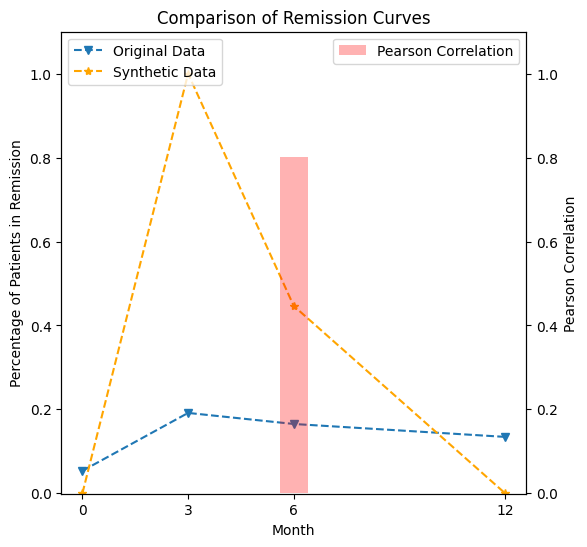

In [114]:
sample_dat = trials[0][0][0]
sample_dat_sub = sample_dat[das_score_cols]
Y = list(sample_dat_sub.mean())

# ax = plt.gca()
# plt.plot(x,y1,'v',linestyle='dashed',label='Original Data')
# plt.plot(x,y2,'*',linestyle='dashed',label='Synthetic Data')

# ax.set_ylim(bottom=-1e-3, top=1.0)
# plt.title("Rate of Remission over Time")
# plt.ylabel("Percentage of Patients in Remission")
# plt.xlabel("Month")


ax = plot_remission_curves(
    title="Comparison of Remission Curves", xlabel="Month", ylabel="Percentage of Patients in Remission",
    Y=Y,
    ax_bottom_limit=-1e-3,
    ax_top_limit=1.1,
    plot_original_curve=True
    )
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.set_ylabel('Pearson Correlation')
ax2.set_ylim(bottom=-1e-3, top=1.1)

#distances = pearsonr(y1, y2, alternative='greater') # the correlation is positive (greater than zero)
distance_single= pearson_correlation(y1,Y)

ax2.bar( 6, distance_single, color=(1.0, 0, 0, 0.3), label='Pearson Correlation'  )
ax2.legend(loc='upper right')

In [115]:
distance_single
#df.corr(trial_performances[:,0])

0.801795655395998

#### Plot

In [116]:
trial_performances = np.zeros((neps, synthesizer_count), dtype=np.float128)
rates = np.zeros((neps, synthesizer_count, K, len(x)), dtype=np.float128)

trial_measures = np.zeros((neps, synthesizer_count, K), dtype=np.float128)
trial_err = np.zeros((neps, synthesizer_count, 2), dtype=np.float128 )

for i in range(neps):
  for j in range(synthesizer_count):
    for k in range(K):
      t = trials[i][j][k]
      rates[i][j][k] = list(t[das_score_cols].mean())
      y2 = rates[i][j][k]
      #distances = [distance.jensenshannon([a,1-a],[b,1-b]) for a,b in zip(y1, y2)]
      #trial_performances[i][j] += np.mean(distances) #Normalize by length of 4, since we have 4 windows (0,3,6,12)
      #trial_performances[i][j] += np.corrcoef(y1,y2)[0][1]

      #trial_performances[i][j] += pearson_correlation(y1,y2)
      trial_measures[i][j][k] = pearson_correlation(y1,y2)
      
    #trial_performances[i][j] /= K
    trial_performances[i,j] = np.median(trial_measures[i,j])
    trial_err[i][j] = [trial_performances[i,j] , -trial_performances[i,j]] + [-1,1] * np.percentile( trial_measures[i,j], [25,75] )
    #print(i,j,trial_err[i][j])
    #print(np.mean( trial_measures[i,j] ))
    #print(np.percentile( trial_measures[i,j], [25,50,75]))
    #print( [trial_performances[i,j] , -trial_performances[i,j]], [-1,1] * np.percentile( trial_measures[i,j], [25,75] ) )

    #trial_err[i][j] = abs(trial_err[i,j]) #Floating point precision can give negative epsilon, abs converts to an appoximation

In [117]:
#trial_err[:,1].T

#print(trial_performances[:][1])

#print(trial_performances[:,1])
#print( [1,-1] * trial_performances[:,1] + [-1,1] * np.percentile( trial_measures[:,1], [25,75],axis=(1) )  ) 

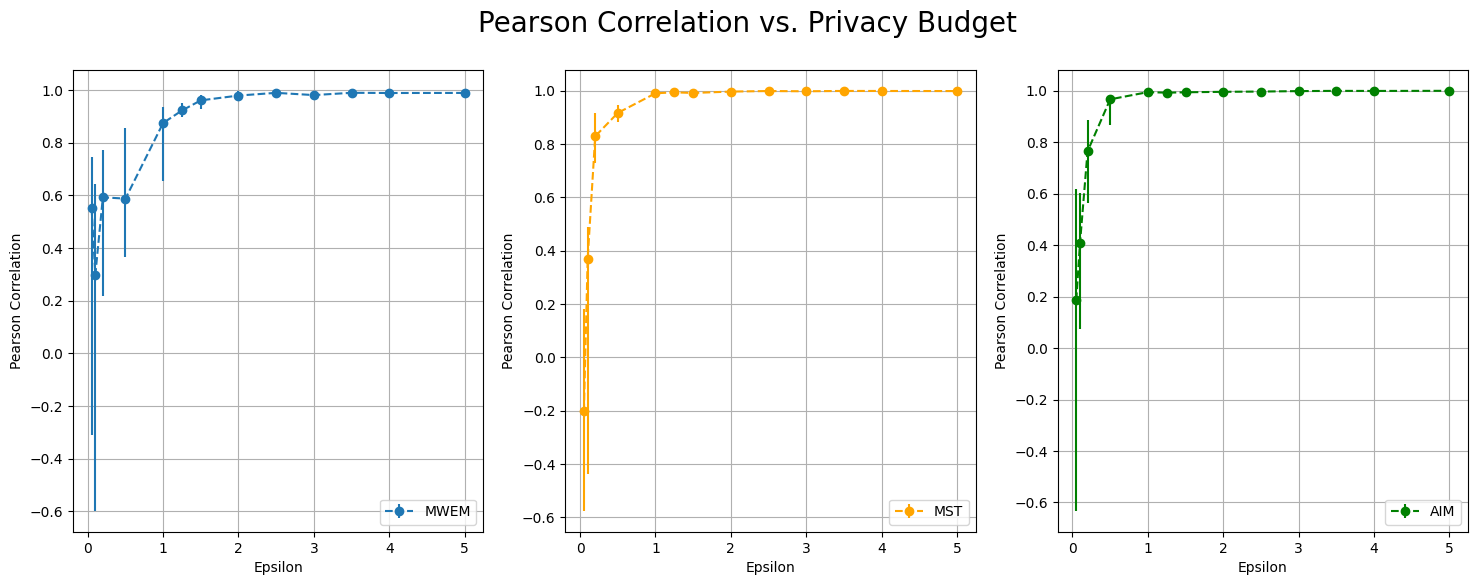

In [118]:
fig= plt.figure(figsize=(18, 6))
# ax.set_title("Total Distance to original Population Time Series")
fig.suptitle("Pearson Correlation vs. Privacy Budget", fontsize=20)

plt.subplot(1,3,1)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
plt.errorbar(eps,trial_performances[:,0], yerr=trial_err[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend(loc='lower right')

plt.subplot(1,3,2)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
plt.errorbar(eps,trial_performances[:,1], yerr=trial_err[:,1].T, fmt='o', linestyle='dashed',color='orange', label='MST')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
plt.legend(loc='lower right')

plt.subplot(1,3,3)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
plt.errorbar(eps,trial_performances[:,2], yerr=trial_err[:,2].T, fmt='o', linestyle='dashed',color='g', label='AIM')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
plt.legend(loc='lower right')


In [119]:
# np.around(trial_performances,4)

for i in range(3):
  a = np.around(trial_performances.T[i],4)
  b = np.around(np.percentile( trial_measures[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x} {y[0], y[1]}" for x,y in zip(a,b)]
  print(pd.DataFrame(res,eps))

                             0
0.05  0.5532 (-0.3117, 0.7453)
0.10   0.298 (-0.5984, 0.6442)
0.20   0.5922 (0.2159, 0.7719)
0.50   0.5873 (0.3648, 0.8571)
1.00    0.8746 (0.656, 0.9369)
1.25   0.9222 (0.8965, 0.9494)
1.50     0.9606 (0.9279, 0.98)
2.00   0.9788 (0.9721, 0.9957)
2.50   0.9891 (0.9792, 0.9972)
3.00    0.9806 (0.9718, 0.991)
3.50   0.9894 (0.9813, 0.9946)
4.00   0.9885 (0.9723, 0.9962)
5.00   0.9888 (0.9861, 0.9958)
                              0
0.05  -0.2029 (-0.5755, 0.1797)
0.10   0.3691 (-0.4374, 0.4887)
0.20     0.829 (0.7301, 0.9172)
0.50    0.9166 (0.8825, 0.9475)
1.00    0.9903 (0.9873, 0.9937)
1.25    0.9938 (0.9894, 0.9968)
1.50    0.9915 (0.9877, 0.9965)
2.00    0.9966 (0.9931, 0.9987)
2.50    0.9987 (0.9979, 0.9999)
3.00    0.9978 (0.9961, 0.9988)
3.50    0.9991 (0.9985, 0.9997)
4.00    0.9989 (0.9979, 0.9994)
5.00    0.9986 (0.9982, 0.9995)
                            0
0.05  0.1861 (-0.632, 0.6162)
0.10  0.4088 (0.0755, 0.6035)
0.20  0.7642 (0.5634, 0.8848

### Mean of Variances

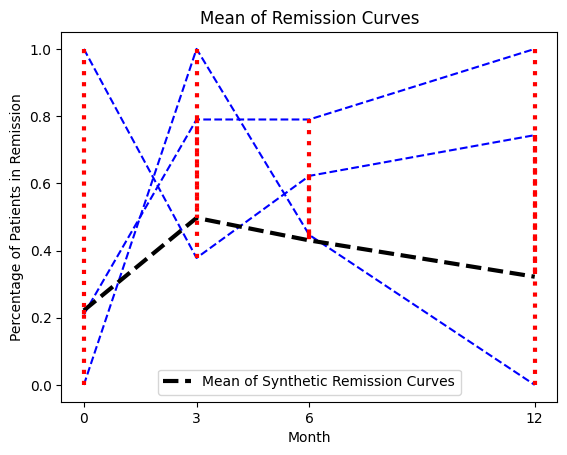

In [120]:
sample_dat_o = trials[0][0][:]
sample_dat_o = [sample_dat_o[i][das_score_cols] for i in range(K)]
yM = np.mean([sample_dat_o[i].mean() for i in range(K)],axis=0) #y Mean

L = 3
sample_dat = trials[0][0][0:L]
sample_dat = [sample_dat[i][das_score_cols] for i in range(L)]
yE = [sample_dat[i].mean() for i in range(L)] #y Examples
#print(y2)

ax = plt.gca()
for i in range(L):
  plt.plot(x,yE[i], color='blue',linestyle='dashed')

plt.plot(x,yM,color='black',linestyle='dashed',lw=3,label='Mean of Synthetic Remission Curves')


for c,i in zip([0,3,6,12],[0,1,2,3]):
  for j in range(L):
    #print(c,i,j)
    #plt.plot([c,c], [yE[j][i],yM[i]], color='black', linestyle='dotted', label='ε=0.05, Algorithm=MWEM')
    plt.plot([c,c], [yE[j][i],yM[i]], color='r', lw=3, linestyle='dotted')

#plt.plot(x,y2,'*',linestyle='dashed',label='Synthetic Data')

#ax.set_ylim(bottom=-1e-3, top=1.0)
plt.title("Mean of Remission Curves")
plt.ylabel("Percentage of Patients in Remission")
plt.xlabel("Month")
plt.xticks(x,x)
# ax2 = ax.twinx()
# ax2.set_ylabel('Sum of Variances')
# ax.set_ylim(bottom=-1e-3, top=1.0+1e-2)

# #distances = [np.var(a,b) for a,b in zip(y1, y2)]
# ax2.bar( x,distances, color=(1.0, 0, 0, 0.3), label='Sum of Variances' )

plt.legend()

In [121]:
rates = np.mean(sample_dat_o,axis=(1))
variances = np.var(rates,axis=(0))
sum_of_variances = np.sum(variances)

print(rates)
print(variances)
print(sum_of_variances)

#len(sample_dat)
#sample_dat[0].shape

# 20x1138x4

[[0.         1.         0.44639719 0.        ]
 [0.21001757 0.78998243 0.78998243 1.        ]
 [1.         0.37785589 0.62214411 0.74340949]
 [0.05184534 0.76977153 0.20474517 0.79525483]
 [0.0026362  0.31810193 0.9973638  0.        ]
 [0.07996485 1.         0.         0.        ]
 [0.01142355 0.         0.         0.00527241]
 [0.13181019 0.69947276 0.56766257 0.        ]
 [0.         0.56414763 0.         0.        ]
 [0.96221441 0.0254833  0.9745167  0.        ]
 [0.         0.92530756 0.99472759 0.0026362 ]
 [0.23725835 0.09490334 0.23725835 0.23725835]
 [0.46309315 0.32952548 0.37873462 0.        ]
 [0.         0.         0.0202109  0.9797891 ]
 [0.00966608 1.         0.94463972 0.        ]
 [0.00878735 1.         0.         0.03514938]
 [0.         0.15553603 0.         0.93057996]
 [0.         0.89279438 0.96660808 0.99033392]
 [0.99648506 0.         0.05711775 0.05360281]
 [0.26713533 0.         0.40070299 0.66783831]]
[0.1174769  0.1560387  0.14993448 0.17119268]
0.59464276696

#### Plot

In [122]:
trial_performances = np.zeros((neps, synthesizer_count))
rates = np.zeros((neps, synthesizer_count, K))

# trial_measures = np.zeros((neps, synthesizer_count, K))
# trial_err = np.zeros((neps, synthesizer_count, 2) )

for i in range(neps):
  for j in range(synthesizer_count):

    #print(i,j)

    sample_dat = trials[i][j][:]
    #print(sample_dat)
    sample_dat = [sample_dat[k][das_score_cols] for k in range(K)]
    #print(sample_dat)

    rates = np.nanmean(sample_dat,axis=(1))
    #print(rates)

    variances = np.var(rates,axis=(0))
    # mean_of_variances = np.mean(variances)
    # print(variances)
    
    trial_performances[i][j] = np.mean(variances)
    # print
    # trial_measures[i,j] = variances
    # trial_err[i][j] = [trial_performances[i,j] , -trial_performances[i,j]] + [-1,1] * np.percentile( variances, [25,75] )
  
  #break

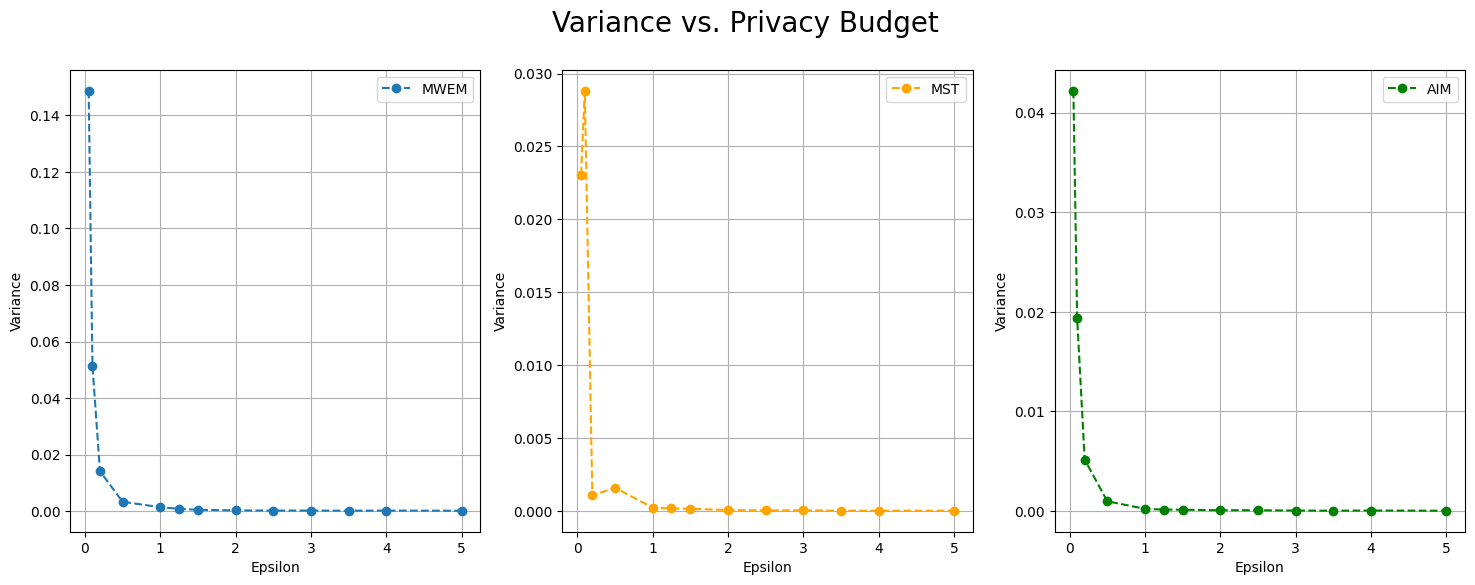

In [123]:
# ax = plt.gca()
# ax.set_yscale('log')
# plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
# plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
# plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
# plt.legend()
# plt.title("Total Variance among Synthetic Data (Sum)")
# plt.ylabel("Sum of Variances (N=20)")
# plt.xlabel("Epsilon")


fig= plt.figure(figsize=(18, 6))
# ax.set_title("Total Distance to original Population Time Series")
fig.suptitle("Variance vs. Privacy Budget", fontsize=20)

plt.subplot(1,3,1)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
# plt.errorbar(eps,trial_performances[:,0], yerr=trial_err[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend(loc='upper right')

plt.subplot(1,3,2)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed',color='orange', label='MST')
# plt.errorbar(eps,trial_performances[:,1], yerr=trial_err[:,1].T, fmt='o', linestyle='dashed',color='orange', label='MST')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
plt.legend(loc='upper right')

plt.subplot(1,3,3)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
plt.plot(eps,trial_performances[:,2], 'o',color='g', linestyle='dashed', label='AIM')
# plt.errorbar(eps,trial_performances[:,2], yerr=trial_err[:,2].T, fmt='o', linestyle='dashed',color='g', label='AIM')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
plt.legend(loc='upper right')


In [124]:
# np.around(trial_performances,4)

for i in range(3):
  a = np.around(trial_performances.T[i],4)
  # b = np.around(np.percentile( trial_measures[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x}" for x in a]
  print(pd.DataFrame(res,eps))

           0
0.05  0.1487
0.10  0.0515
0.20  0.0141
0.50  0.0034
1.00  0.0014
1.25  0.0009
1.50  0.0005
2.00  0.0003
2.50  0.0002
3.00  0.0002
3.50  0.0002
4.00  0.0002
5.00  0.0002
           0
0.05  0.0231
0.10  0.0288
0.20  0.0011
0.50  0.0016
1.00  0.0002
1.25  0.0002
1.50  0.0001
2.00  0.0001
2.50     0.0
3.00     0.0
3.50     0.0
4.00     0.0
5.00     0.0
           0
0.05  0.0422
0.10  0.0193
0.20  0.0051
0.50   0.001
1.00  0.0002
1.25  0.0001
1.50  0.0001
2.00  0.0001
2.50  0.0001
3.00     0.0
3.50     0.0
4.00     0.0
5.00     0.0


# Part 2

In [125]:
# Recompute y1 for m/f

dat_m = dat[dat['sex']=='male'][das_score_cols]
dat_f = dat[dat['sex']=='female'][das_score_cols]
y1_m = list(dat_m.mean())
y1_f = list(dat_f.mean())

# Recompute differences?

## Normalized Pairwise Jenson-Shannon Distance

In [126]:
# baseline distance
baseline_distance = np.mean(jensen_shannon_distances(y1_m, y1_f))
print(baseline_distance)

0.03467606150302519


In [127]:
trial_performances_2_m = np.zeros((neps, synthesizer_count))
trial_performances_2_f = np.zeros((neps, synthesizer_count))
trial_performances_2_diff = np.zeros((neps, synthesizer_count))

rates_2_m = np.zeros((neps, synthesizer_count, K, len(x)))
rates_2_f = np.zeros((neps, synthesizer_count, K, len(x)))
rates_2_diff = np.zeros((neps, synthesizer_count, K, len(x)))

trial_measures_m = np.zeros((neps, synthesizer_count, K))
trial_err_m = np.zeros((neps, synthesizer_count, 2))
trial_measures_f = np.zeros((neps, synthesizer_count, K))
trial_err_f = np.zeros((neps, synthesizer_count, 2))
trial_measures_diff = np.zeros((neps, synthesizer_count, K))
trial_err_diff = np.zeros((neps, synthesizer_count, 2))

baseline_distance = np.mean(jensen_shannon_distances(y1_m, y1_f))

for i in range(neps):
  for j in range(synthesizer_count):
    for k in range(K):
      # print(i,j,k)
      t = trials[i][j][k]

      rates_2_m[i][j][k] = list(t[t['sex']=='male'][das_score_cols].mean())
      rates_2_f[i][j][k] = list(t[t['sex']=='female'][das_score_cols].mean())

      y2_m = rates_2_m[i][j][k]
      distances = jensen_shannon_distances(y1_m, y2_m)
      trial_measures_m[i,j,k] = np.mean(distances) #Normalize by length of 4, since we have 4 windows (0,3,6,12)

      y2_f = rates_2_f[i][j][k]
      distances = jensen_shannon_distances(y1_f, y2_f)
      trial_measures_f[i,j,k] = np.mean(distances) #Normalize by length of 4, since we have 4 windows (0,3,6,12)

      distances = jensen_shannon_distances(y2_m, y2_f)
      trial_measures_diff[i,j,k] = np.mean(distances) #Normalize by length of 4, since we have 4 windows (0,3,6,12)
    
    trial_performances_2_m[i][j] = np.nanmedian(trial_measures_m[i][j])
    trial_err_m[i][j] = [trial_performances_2_m[i,j] , -trial_performances_2_m[i,j]] + [-1,1] * np.nanpercentile( trial_measures_m[i,j], [25,75] )
    
    trial_performances_2_f[i][j] = np.nanmedian(trial_measures_f[i][j])
    trial_err_f[i][j] = [trial_performances_2_f[i,j] , -trial_performances_2_f[i,j]] + [-1,1] * np.nanpercentile( trial_measures_f[i,j], [25,75] )

    trial_performances_2_diff[i][j] = np.nanmedian(trial_measures_diff[i][j])
    trial_err_diff[i][j] = [trial_performances_2_diff[i,j] , -trial_performances_2_diff[i,j]] + [-1,1] * np.nanpercentile( trial_measures_diff[i,j], [25,75] )


In [128]:
# a = [0.05925925925925926, 0.1765432098765432, 0.15308641975308643, 0.12839506172839507]
# b = [1,        0.59556787, 0.40443213, 0.59556787]

# np.mean(jensen_shannon_distances(a, b))

Text(0.5, 0, 'Epsilon')

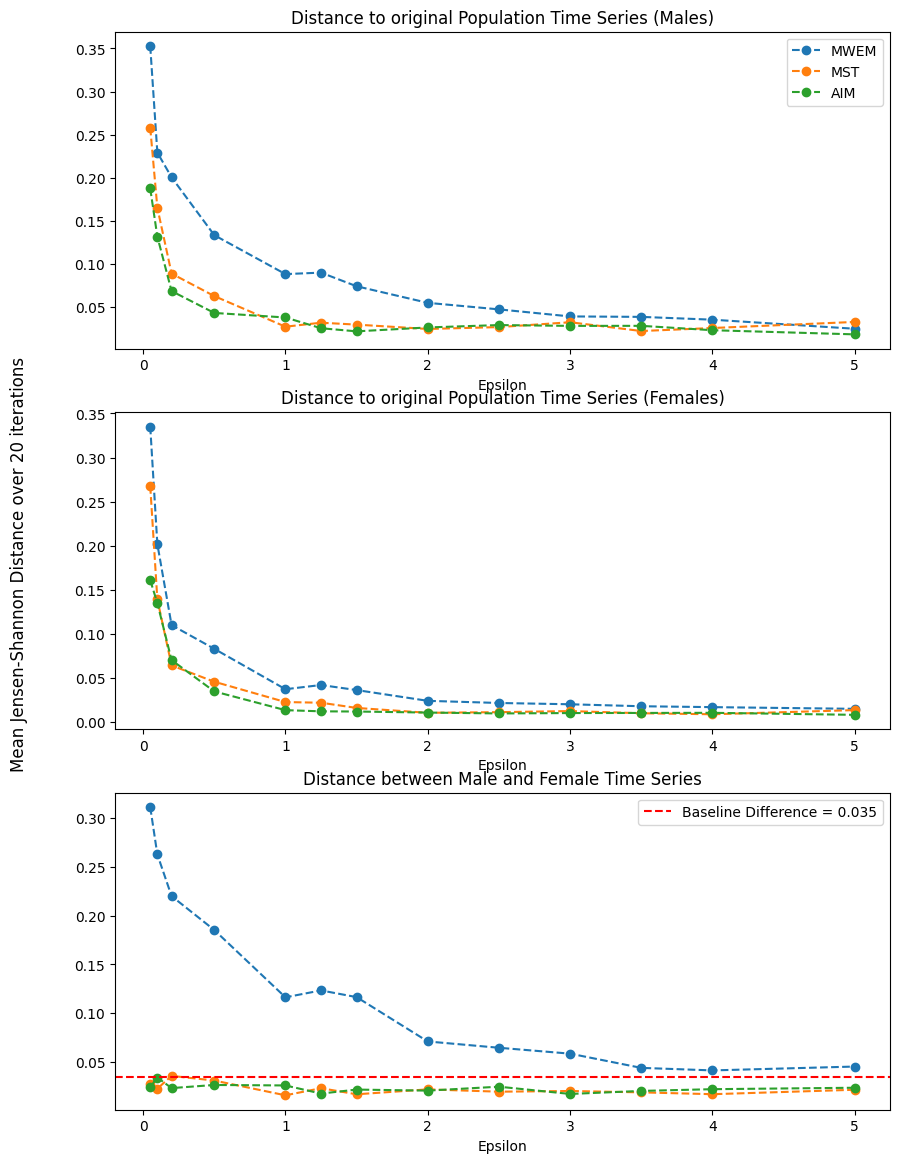

In [129]:
fig = plt.figure(figsize=(10,14))

fig.supylabel("Mean Jensen-Shannon Distance over 20 iterations")
ax.set_yscale('log')
plt.subplot(3,1,1)
plt.plot(eps,trial_performances_2_m[:,0], 'o', linestyle='dashed', label='MWEM')
plt.plot(eps,trial_performances_2_m[:,1], 'o', linestyle='dashed', label='MST')
plt.plot(eps,trial_performances_2_m[:,2], 'o', linestyle='dashed', label='AIM')
plt.legend()
plt.title("Distance to original Population Time Series (Males)")
#plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
plt.xlabel("Epsilon")


plt.subplot(3,1,2)
plt.plot(eps,trial_performances_2_f[:,0], 'o', linestyle='dashed', label='MWEM')
plt.plot(eps,trial_performances_2_f[:,1], 'o', linestyle='dashed', label='MST')
plt.plot(eps,trial_performances_2_f[:,2], 'o', linestyle='dashed', label='AIM')

plt.title("Distance to original Population Time Series (Females)")
#plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
plt.xlabel("Epsilon")

plt.subplot(3,1,3)
# plt.plot(eps,trial_performances_2_diff[:,0], 'o', linestyle='dashed', label='MWEM')
# plt.plot(eps,trial_performances_2_diff[:,1], 'o', linestyle='dashed', label='MST')
# plt.plot(eps,trial_performances_2_diff[:,2], 'o', linestyle='dashed', label='AIM')

plt.plot(eps,trial_performances_2_diff[:,0], 'o', linestyle='dashed')
plt.plot(eps,trial_performances_2_diff[:,1], 'o', linestyle='dashed')
plt.plot(eps,trial_performances_2_diff[:,2], 'o', linestyle='dashed')

plt.axhline(y=baseline_distance, color='red', linestyle='--', label='Baseline Difference = 0.035')

plt.legend()
plt.title("Distance between Male and Female Time Series")
#plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
plt.xlabel("Epsilon")

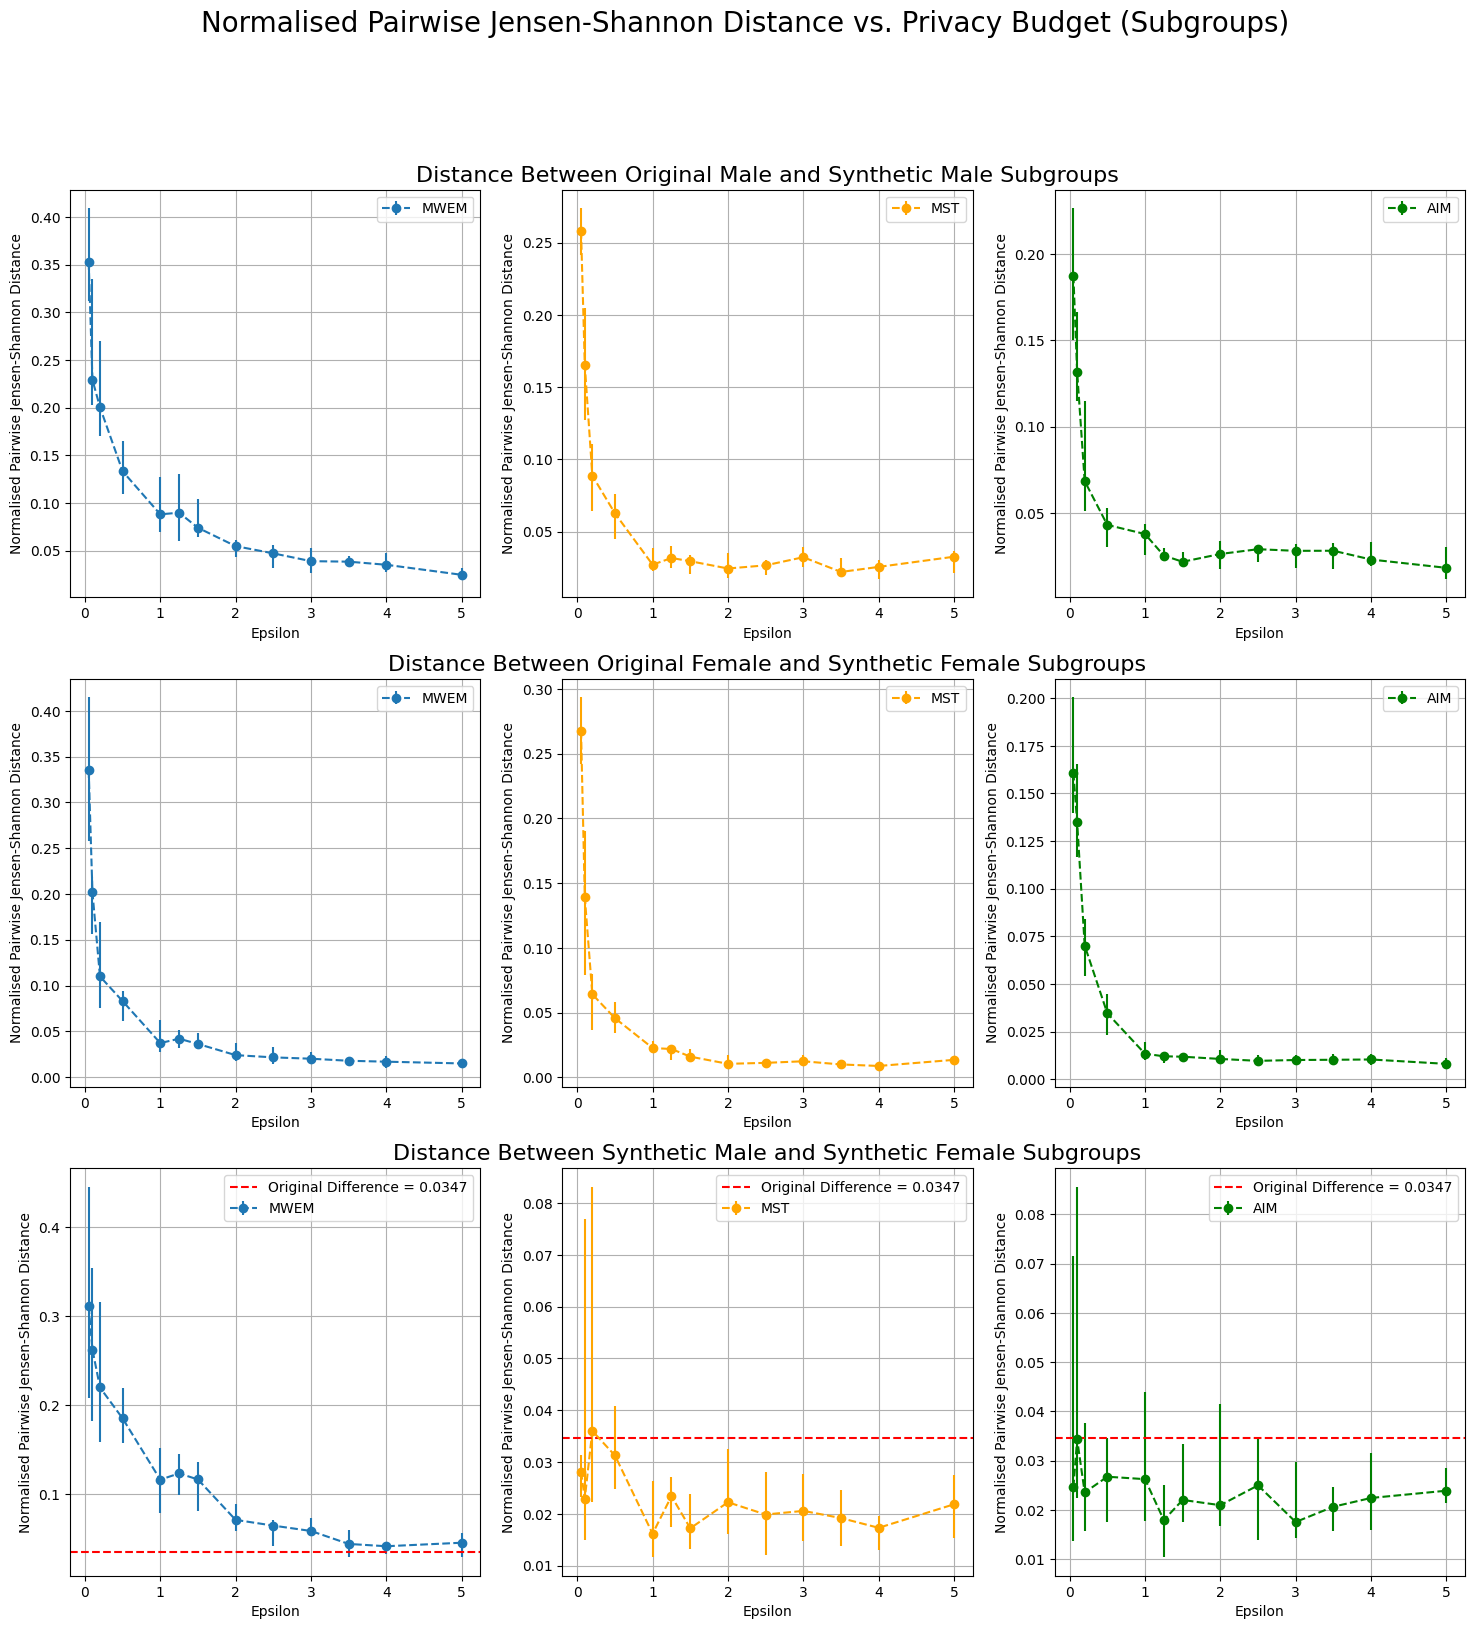

In [130]:
fig = plt.figure(figsize=(18, 18))
# plt.title("Mean Jensen-Shannon Distance over 20 iterations")
#ax = plt.gca()
#fig.supxlabel()
#fig, ax = plt.subplots(1,3)

# print(trial_performances[:,0].shape)


#yerr=[range(1,11),range(1,11)]
#yerr= [ np.percentile(rates[i][0], [75 ,25]) for i in range(len(eps)) ]
#print(yerr)

# print(trial_err[:,0].T)

fig.suptitle("Normalised Pairwise Jensen-Shannon Distance vs. Privacy Budget (Subgroups)", fontsize=20)

plt.subplot(3,3,1)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
plt.errorbar(eps,trial_performances_2_m[:,0], yerr=trial_err_m[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend()

plt.subplot(3,3,2)

ax = plt.gca()
ax.grid()
ax.set_title('Distance Between Original Male and Synthetic Male Subgroups', fontsize=16, loc='center')
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
plt.errorbar(eps,trial_performances_2_m[:,1], yerr=trial_err_m[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
plt.legend()

plt.subplot(3,3,3)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
plt.errorbar(eps,trial_performances_2_m[:,2], yerr=trial_err_m[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
plt.legend()

# ;kdas;lskf;ldskfl;sdkf;lksdf


plt.subplot(3,3,4)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
plt.errorbar(eps,trial_performances_2_f[:,0], yerr=trial_err_f[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend()

plt.subplot(3,3,5)

ax = plt.gca()
ax.grid()
ax.set_title('Distance Between Original Female and Synthetic Female Subgroups', fontsize=16, loc='center')
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
plt.errorbar(eps,trial_performances_2_f[:,1], yerr=trial_err_f[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
plt.legend()

plt.subplot(3,3,6)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
plt.errorbar(eps,trial_performances_2_f[:,2], yerr=trial_err_f[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
plt.legend()

# ;kdas;lskf;ldskfl;sdkf;lksdf


plt.subplot(3,3,7)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
plt.errorbar(eps,trial_performances_2_diff[:,0], yerr=trial_err_diff[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.axhline(y=baseline_distance, color='red', linestyle='--', label='Original Difference = 0.0347')
plt.legend()

plt.subplot(3,3,8)

ax = plt.gca()
ax.grid()
ax.set_title('Distance Between Synthetic Male and Synthetic Female Subgroups', fontsize=16, loc='center')
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
plt.errorbar(eps,trial_performances_2_diff[:,1], yerr=trial_err_diff[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
plt.axhline(y=baseline_distance, color='red', linestyle='--', label='Original Difference = 0.0347')
plt.legend()

plt.subplot(3,3,9)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
plt.errorbar(eps,trial_performances_2_diff[:,2], yerr=trial_err_diff[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Normalised Pairwise Jensen-Shannon Distance")
plt.xlabel("Epsilon")
plt.axhline(y=baseline_distance, color='red', linestyle='--', label='Original Difference = 0.0347')
plt.legend()

In [131]:

# print(np.around(trial_performances_2_m,4))
# print(np.around(trial_performances_2_f,4))
# print(np.around(trial_performances_2_diff,4))


for i in range(3):
  a = np.around(trial_performances_2_m.T[i],4)
  b = np.around(np.nanpercentile( trial_measures_m[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x} {y[0], y[1]}" for x,y in zip(a,b)]
  print(pd.DataFrame(res,eps))

print('***********************************')
for i in range(3):
  a = np.around(trial_performances_2_f.T[i],4)
  b = np.around(np.nanpercentile( trial_measures_f[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x} {y[0], y[1]}" for x,y in zip(a,b)]
  print(pd.DataFrame(res,eps))
print('***********************************')

for i in range(3):
  a = np.around(trial_performances_2_diff.T[i],4)
  b = np.around(np.nanpercentile( trial_measures_diff[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x} {y[0], y[1]}" for x,y in zip(a,b)]
  print(pd.DataFrame(res,eps))

                            0
0.05  0.3527 (0.3116, 0.4091)
0.10   0.2291 (0.2024, 0.335)
0.20    0.2004 (0.17, 0.2698)
0.50  0.1333 (0.1094, 0.1649)
1.00  0.0881 (0.0692, 0.1269)
1.25    0.0898 (0.06, 0.1299)
1.50   0.074 (0.0645, 0.1042)
2.00   0.0547 (0.0437, 0.061)
2.50  0.0471 (0.0317, 0.0563)
3.00    0.039 (0.027, 0.0529)
3.50  0.0384 (0.0339, 0.0448)
4.00  0.0352 (0.0278, 0.0472)
5.00  0.0246 (0.0204, 0.0317)
                            0
0.05   0.258 (0.2415, 0.2737)
0.10  0.1651 (0.1272, 0.2047)
0.20  0.0887 (0.0643, 0.1106)
0.50  0.0626 (0.0451, 0.0762)
1.00   0.027 (0.0229, 0.0389)
1.25   0.0317 (0.025, 0.0399)
1.50  0.0294 (0.0204, 0.0339)
2.00  0.0244 (0.0178, 0.0351)
2.50  0.0266 (0.0196, 0.0304)
3.00  0.0322 (0.0253, 0.0395)
3.50   0.022 (0.0186, 0.0318)
4.00  0.0255 (0.0172, 0.0303)
5.00  0.0326 (0.0213, 0.0366)
                            0
0.05    0.1875 (0.15, 0.2265)
0.10  0.1316 (0.1149, 0.1666)
0.20  0.0684 (0.0513, 0.1148)
0.50   0.043 (0.0299, 0.0531)
1.00  0.03

## Pearson Correlations



In [132]:
print(pearson_correlation(y1_m, y1_f))

0.9995594672632673


In [133]:
trial_performances_2_m = np.zeros((neps, synthesizer_count))
trial_performances_2_f = np.zeros((neps, synthesizer_count))
trial_performances_2_diff = np.zeros((neps, synthesizer_count))

rates_2_m = np.zeros((neps, synthesizer_count, K, len(x)))
rates_2_f = np.zeros((neps, synthesizer_count, K, len(x)))
rates_2_diff = np.zeros((neps, synthesizer_count, K, len(x)))

trial_measures_m = np.zeros((neps, synthesizer_count, K))
trial_err_m = np.zeros((neps, synthesizer_count, 2))
trial_measures_f = np.zeros((neps, synthesizer_count, K))
trial_err_f = np.zeros((neps, synthesizer_count, 2))
trial_measures_diff = np.zeros((neps, synthesizer_count, K))
trial_err_diff = np.zeros((neps, synthesizer_count, 2))

baseline_distance = pearson_correlation(y1_m, y1_f)
# print(y1_m)
# print(y1_f)
# print(baseline_distance)

for i in range(neps):
  for j in range(synthesizer_count):
    for k in range(K):
      #print(i,j,k)
      t = trials[i][j][k]

      rates_2_m[i][j][k] = list(t[t['sex']=='male'][das_score_cols].mean())
      rates_2_f[i][j][k] = list(t[t['sex']=='female'][das_score_cols].mean())

      y2_m = rates_2_m[i][j][k]
      # need a nan guard
      if np.isnan(np.min(y2_m)):
        trial_measures_m[i,j,k] = np.nan
      else:
        trial_measures_m[i,j,k] = pearson_correlation(y1_m, y2_m)

      y2_f = rates_2_f[i][j][k]
      # need a nan guard
      if np.isnan(np.min(y2_f)):
        trial_measures_f[i,j,k] = np.nan
      else:
        trial_measures_f[i,j,k] = pearson_correlation(y1_f, y2_f)

      # need a nan guard
      if np.isnan(np.min(y2_m)) or np.isnan(np.min(y2_f)):
        trial_measures_diff[i,j,k] = np.nan
      else:
        trial_measures_diff[i,j,k] = pearson_correlation(y2_m, y2_f)

    trial_performances_2_m[i][j] = np.nanmedian(trial_measures_m[i][j])
    trial_err_m[i][j] = [trial_performances_2_m[i,j] , -trial_performances_2_m[i,j]] + [-1,1] * np.percentile( trial_measures_m[i,j], [25,75] )
    
    trial_performances_2_f[i][j] = np.nanmedian(trial_measures_f[i][j])
    trial_err_f[i][j] = [trial_performances_2_f[i,j] , -trial_performances_2_f[i,j]] + [-1,1] * np.percentile( trial_measures_f[i,j], [25,75] )

    trial_performances_2_diff[i][j] = np.nanmedian(trial_measures_diff[i][j])
    trial_err_diff[i][j] = [trial_performances_2_diff[i,j] , -trial_performances_2_diff[i,j]] + [-1,1] * np.percentile( trial_measures_diff[i,j], [25,75] )
    

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2829: RuntimeWa

In [134]:
# trial_measures_m[0][0]

Text(0.5, 0, 'Epsilon')

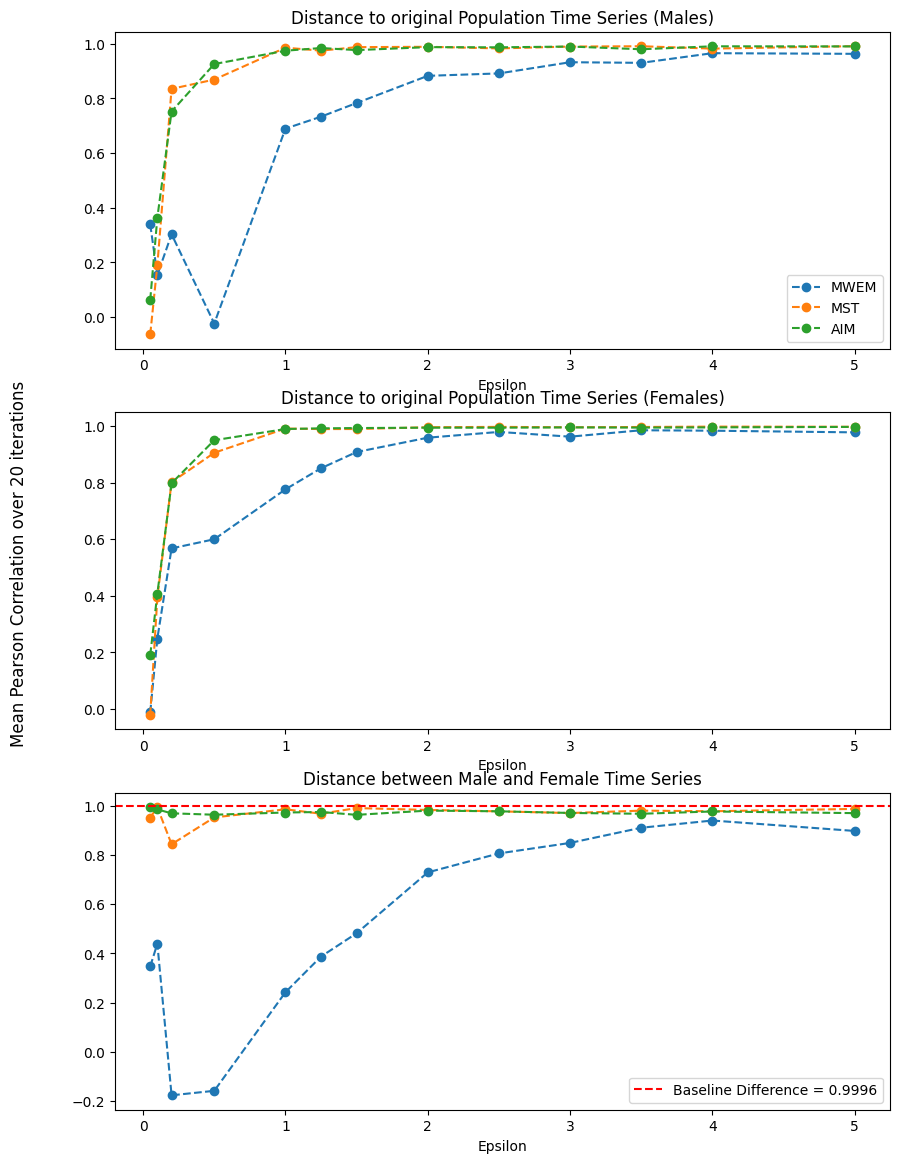

In [135]:
fig = plt.figure(figsize=(10,14))

fig.supylabel("Mean Pearson Correlation over 20 iterations")

plt.subplot(3,1,1)
plt.plot(eps,trial_performances_2_m[:,0], 'o', linestyle='dashed', label='MWEM')
plt.plot(eps,trial_performances_2_m[:,1], 'o', linestyle='dashed', label='MST')
plt.plot(eps,trial_performances_2_m[:,2], 'o', linestyle='dashed', label='AIM')
plt.legend()
plt.title("Distance to original Population Time Series (Males)")
#plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
plt.xlabel("Epsilon")


plt.subplot(3,1,2)
plt.plot(eps,trial_performances_2_f[:,0], 'o', linestyle='dashed', label='MWEM')
plt.plot(eps,trial_performances_2_f[:,1], 'o', linestyle='dashed', label='MST')
plt.plot(eps,trial_performances_2_f[:,2], 'o', linestyle='dashed', label='AIM')

plt.title("Distance to original Population Time Series (Females)")
#plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
plt.xlabel("Epsilon")

plt.subplot(3,1,3)
# plt.plot(eps,trial_performances_2_diff[:,0], 'o', linestyle='dashed', label='MWEM')
# plt.plot(eps,trial_performances_2_diff[:,1], 'o', linestyle='dashed', label='MST')
# plt.plot(eps,trial_performances_2_diff[:,2], 'o', linestyle='dashed', label='AIM')

plt.plot(eps,trial_performances_2_diff[:,0], 'o', linestyle='dashed')
plt.plot(eps,trial_performances_2_diff[:,1], 'o', linestyle='dashed')
plt.plot(eps,trial_performances_2_diff[:,2], 'o', linestyle='dashed')

plt.axhline(y=baseline_distance, color='red', linestyle='--', label='Baseline Difference = 0.9996')

plt.legend()
plt.title("Distance between Male and Female Time Series")
#plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
plt.xlabel("Epsilon")

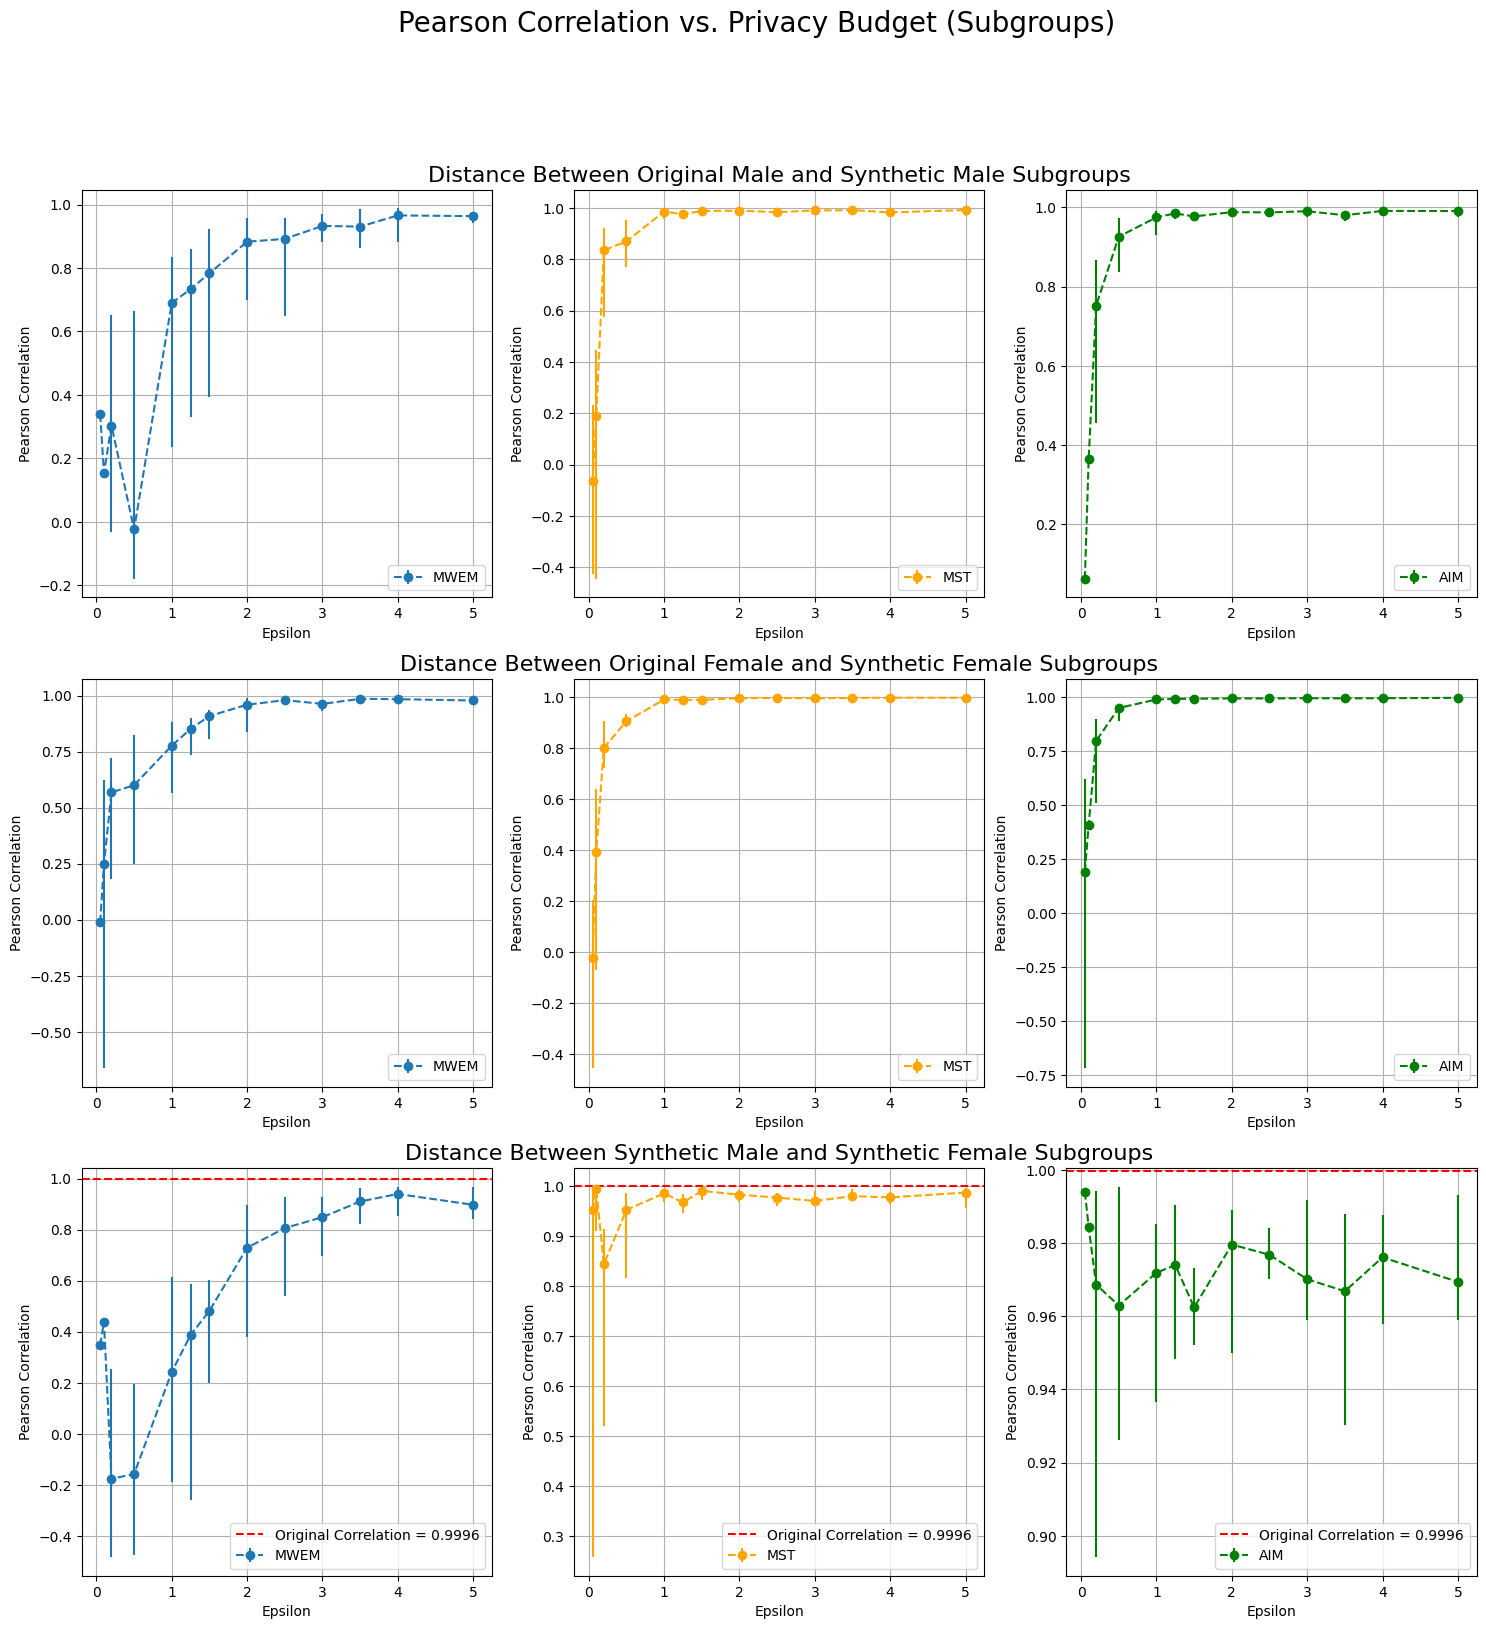

In [136]:
fig = plt.figure(figsize=(18, 18))
# plt.title("Mean Jensen-Shannon Distance over 20 iterations")
#ax = plt.gca()
#fig.supxlabel()
#fig, ax = plt.subplots(1,3)

# print(trial_performances[:,0].shape)


#yerr=[range(1,11),range(1,11)]
#yerr= [ np.percentile(rates[i][0], [75 ,25]) for i in range(len(eps)) ]
#print(yerr)

# print(trial_err[:,0].T)

fig.suptitle("Pearson Correlation vs. Privacy Budget (Subgroups)", fontsize=20)

plt.subplot(3,3,1)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
plt.errorbar(eps,trial_performances_2_m[:,0], yerr=trial_err_m[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend(loc='lower right')

plt.subplot(3,3,2)

ax = plt.gca()
ax.grid()
ax.set_title('Distance Between Original Male and Synthetic Male Subgroups', fontsize=16, loc='center')
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
plt.errorbar(eps,trial_performances_2_m[:,1], yerr=trial_err_m[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
plt.legend(loc='lower right')

plt.subplot(3,3,3)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
plt.errorbar(eps,trial_performances_2_m[:,2], yerr=trial_err_m[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
plt.legend(loc='lower right')

# ;kdas;lskf;ldskfl;sdkf;lksdf


plt.subplot(3,3,4)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
plt.errorbar(eps,trial_performances_2_f[:,0], yerr=trial_err_f[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend(loc='lower right')

plt.subplot(3,3,5)

ax = plt.gca()
ax.grid()
ax.set_title('Distance Between Original Female and Synthetic Female Subgroups', fontsize=16, loc='center')
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
plt.errorbar(eps,trial_performances_2_f[:,1], yerr=trial_err_f[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
plt.legend(loc='lower right')

plt.subplot(3,3,6)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
plt.errorbar(eps,trial_performances_2_f[:,2], yerr=trial_err_f[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
plt.legend(loc='lower right')

# ;kdas;lskf;ldskfl;sdkf;lksdf


plt.subplot(3,3,7)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,0], 'o', linestyle='dashed', label='MWEM')
plt.errorbar(eps,trial_performances_2_diff[:,0], yerr=trial_err_diff[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.axhline(y=baseline_distance, color='red', linestyle='--', label='Original Correlation = 0.9996')
plt.legend(loc='lower right')

plt.subplot(3,3,8)

ax = plt.gca()
ax.grid()
ax.set_title('Distance Between Synthetic Male and Synthetic Female Subgroups', fontsize=16, loc='center')
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,1], 'o', linestyle='dashed', label='MST')
plt.errorbar(eps,trial_performances_2_diff[:,1], yerr=trial_err_diff[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
plt.axhline(y=baseline_distance, color='red', linestyle='--', label='Original Correlation = 0.9996')
plt.legend(loc='lower right')

plt.subplot(3,3,9)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
#plt.plot(eps,trial_performances[:,2], 'o', linestyle='dashed', label='AIM')
plt.errorbar(eps,trial_performances_2_diff[:,2], yerr=trial_err_diff[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Pearson Correlation")
plt.xlabel("Epsilon")
plt.axhline(y=baseline_distance, color='red', linestyle='--', label='Original Correlation = 0.9996')
plt.legend(loc='lower right')

In [137]:

# print(np.around(trial_performances_2_m,4))
# print(np.around(trial_performances_2_f,4))
# print(np.around(trial_performances_2_diff,4))


for i in range(3):
  a = np.around(trial_performances_2_m.T[i],4)
  b = np.around(np.nanpercentile( trial_measures_m[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x} {y[0], y[1]}" for x,y in zip(a,b)]
  print(pd.DataFrame(res,eps))

print('***********************************')
for i in range(3):
  a = np.around(trial_performances_2_f.T[i],4)
  b = np.around(np.nanpercentile( trial_measures_f[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x} {y[0], y[1]}" for x,y in zip(a,b)]
  print(pd.DataFrame(res,eps))
print('***********************************')

for i in range(3):
  a = np.around(trial_performances_2_diff.T[i],4)
  b = np.around(np.nanpercentile( trial_measures_diff[:,i], [25,75], axis=1 ).T, 4)
  res = [f"{x} {y[0], y[1]}" for x,y in zip(a,b)]
  print(pd.DataFrame(res,eps))

                              0
0.05    0.3392 (0.0645, 0.6106)
0.10   0.1542 (-0.5292, 0.7425)
0.20   0.3031 (-0.0308, 0.6506)
0.50  -0.0235 (-0.1797, 0.6647)
1.00    0.6896 (0.2348, 0.8338)
1.25    0.7334 (0.3315, 0.8593)
1.50     0.7834 (0.3927, 0.922)
2.00    0.8829 (0.7002, 0.9559)
2.50    0.8917 (0.6475, 0.9565)
3.00    0.9326 (0.8831, 0.9703)
3.50    0.9304 (0.8625, 0.9866)
4.00    0.9657 (0.8817, 0.9882)
5.00    0.9633 (0.9405, 0.9735)
                             0
0.05  -0.0632 (-0.4239, 0.232)
0.10   0.1901 (-0.4444, 0.445)
0.20   0.8351 (0.5754, 0.9206)
0.50   0.8692 (0.7687, 0.9518)
1.00   0.9858 (0.9561, 0.9924)
1.25   0.9751 (0.9637, 0.9863)
1.50   0.9878 (0.9803, 0.9919)
2.00   0.9891 (0.9773, 0.9965)
2.50   0.9832 (0.9787, 0.9941)
3.00   0.9899 (0.9749, 0.9939)
3.50   0.9911 (0.9848, 0.9957)
4.00   0.9824 (0.9759, 0.9922)
5.00     0.9915 (0.97, 0.9985)
                             0
0.05  0.0629 (-0.3156, 0.3994)
0.10  0.3641 (-0.0308, 0.7878)
0.20   0.7523 (0.4555, 0.

## Mean of Variances

In [138]:
trial_performances_2_m = np.zeros((neps, synthesizer_count))
trial_performances_2_f = np.zeros((neps, synthesizer_count))
trial_performances_2_diff = np.zeros((neps, synthesizer_count))

rates_2_m = np.zeros((neps, synthesizer_count, K, len(x)))
rates_2_f = np.zeros((neps, synthesizer_count, K, len(x)))
rates_2_diff = np.zeros((neps, synthesizer_count, K, len(x)))

dat_male = dat[dat['sex']=='male']
dat_female = dat[dat['sex']=='female']

#rates_male = np.nanmean(dat_male[das_score_cols],axis=(1))
#rates_female = np.mean(dat_male[das_score_cols],axis=(1))


for i in range(neps):
  for j in range(synthesizer_count):
    rates_male = []
    rates_female = []
    for k in range(K):
    #   #print(i,j,k)
    #   #t = trials[i][j][k]

    #   rates_2_m[i][j][k] = list(t[t['sex']=='male'][das_score_cols].mean())
    #   rates_2_f[i][j][k] = list(t[t['sex']=='female'][das_score_cols].mean())

      #print(j,k,rates)

      # STEP 1: Select Trials[i][j]

      trial_dat = trials[i][j][k]

      # STEP 2: Seperate Males and Females
      sample_dat_male = (trial_dat[trial_dat['sex']=='male'][das_score_cols])
      sample_dat_female = (trial_dat[trial_dat['sex']=='female'][das_score_cols])

      #print(sample_dat_male[0].shape)

      #rates_male = [X.shape for X in sample_dat_male]
      #rates_female = [np.nanmean(X,axis=(0)) for X in sample_dat_female]
      rates_male.append( np.nanmean(sample_dat_male,axis=(0)) )
      rates_female.append( np.nanmean(sample_dat_female,axis=(0)) )

      #print(rates_female)
      #break
    variances_male = np.nanvar(rates_male,axis=(0))
    variances_female = np.nanvar(rates_female,axis=(0))
    
    mean_of_variances_male = np.nanmean(variances_male)
    mean_of_variances_female = np.nanmean(variances_female)

    trial_performances_2_m[i][j] = mean_of_variances_male
    trial_performances_2_f[i][j] = mean_of_variances_female

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-138-ed9e55bdfabb>:41: RuntimeWarning: Mean of empty slice


Text(0.5, 0, 'Epsilon')

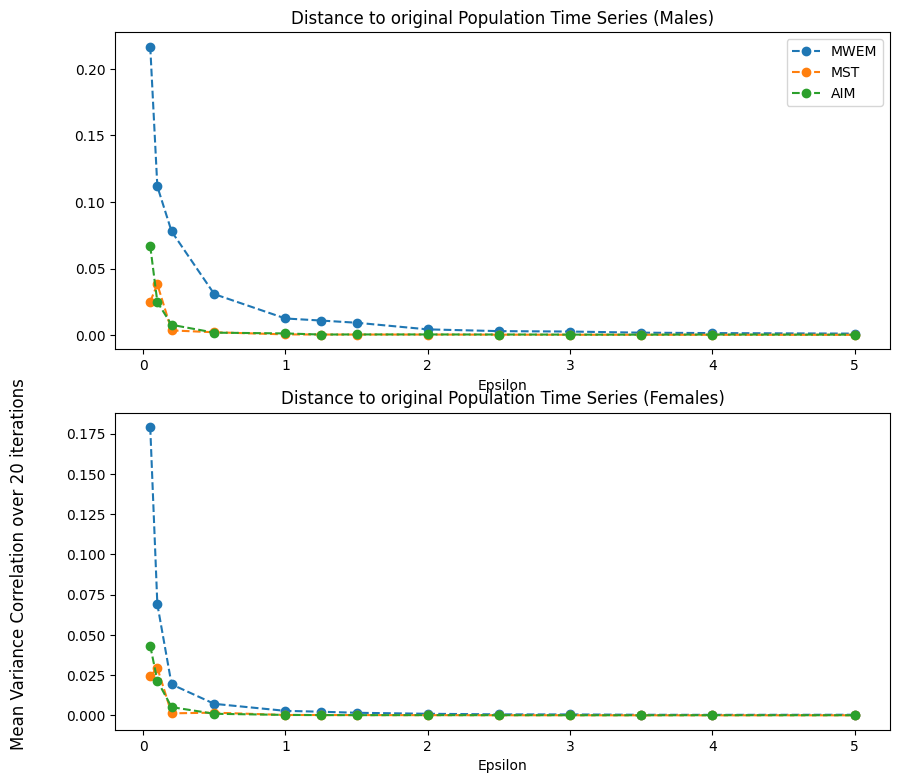

In [139]:
fig = plt.figure(figsize=(10,14))
ax.set_yscale('log')
fig.supylabel("Mean Variance Correlation over 20 iterations")

plt.subplot(3,1,1)
plt.plot(eps,trial_performances_2_m[:,0], 'o', linestyle='dashed', label='MWEM')
plt.plot(eps,trial_performances_2_m[:,1], 'o', linestyle='dashed', label='MST')
plt.plot(eps,trial_performances_2_m[:,2], 'o', linestyle='dashed', label='AIM')
plt.legend()
plt.title("Distance to original Population Time Series (Males)")
#plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
plt.xlabel("Epsilon")


plt.subplot(3,1,2)
plt.plot(eps,trial_performances_2_f[:,0], 'o', linestyle='dashed', label='MWEM')
plt.plot(eps,trial_performances_2_f[:,1], 'o', linestyle='dashed', label='MST')
plt.plot(eps,trial_performances_2_f[:,2], 'o', linestyle='dashed', label='AIM')

plt.title("Distance to original Population Time Series (Females)")
#plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
plt.xlabel("Epsilon")

# plt.subplot(3,1,3)
# # plt.plot(eps,trial_performances_2_diff[:,0], 'o', linestyle='dashed', label='MWEM')
# # plt.plot(eps,trial_performances_2_diff[:,1], 'o', linestyle='dashed', label='MST')
# # plt.plot(eps,trial_performances_2_diff[:,2], 'o', linestyle='dashed', label='AIM')

# plt.plot(eps,trial_performances_2_diff[:,0], 'o', linestyle='dashed')
# plt.plot(eps,trial_performances_2_diff[:,1], 'o', linestyle='dashed')
# plt.plot(eps,trial_performances_2_diff[:,2], 'o', linestyle='dashed')

# plt.axhline(y=baseline_distance, color='red', linestyle='--', label='True Distance')

# plt.legend()
# plt.title("Distance between Male and Female Time Series")
# #plt.ylabel("Mean Jensen-Shannon Distance over 5 iterations")
# plt.xlabel("Epsilon")

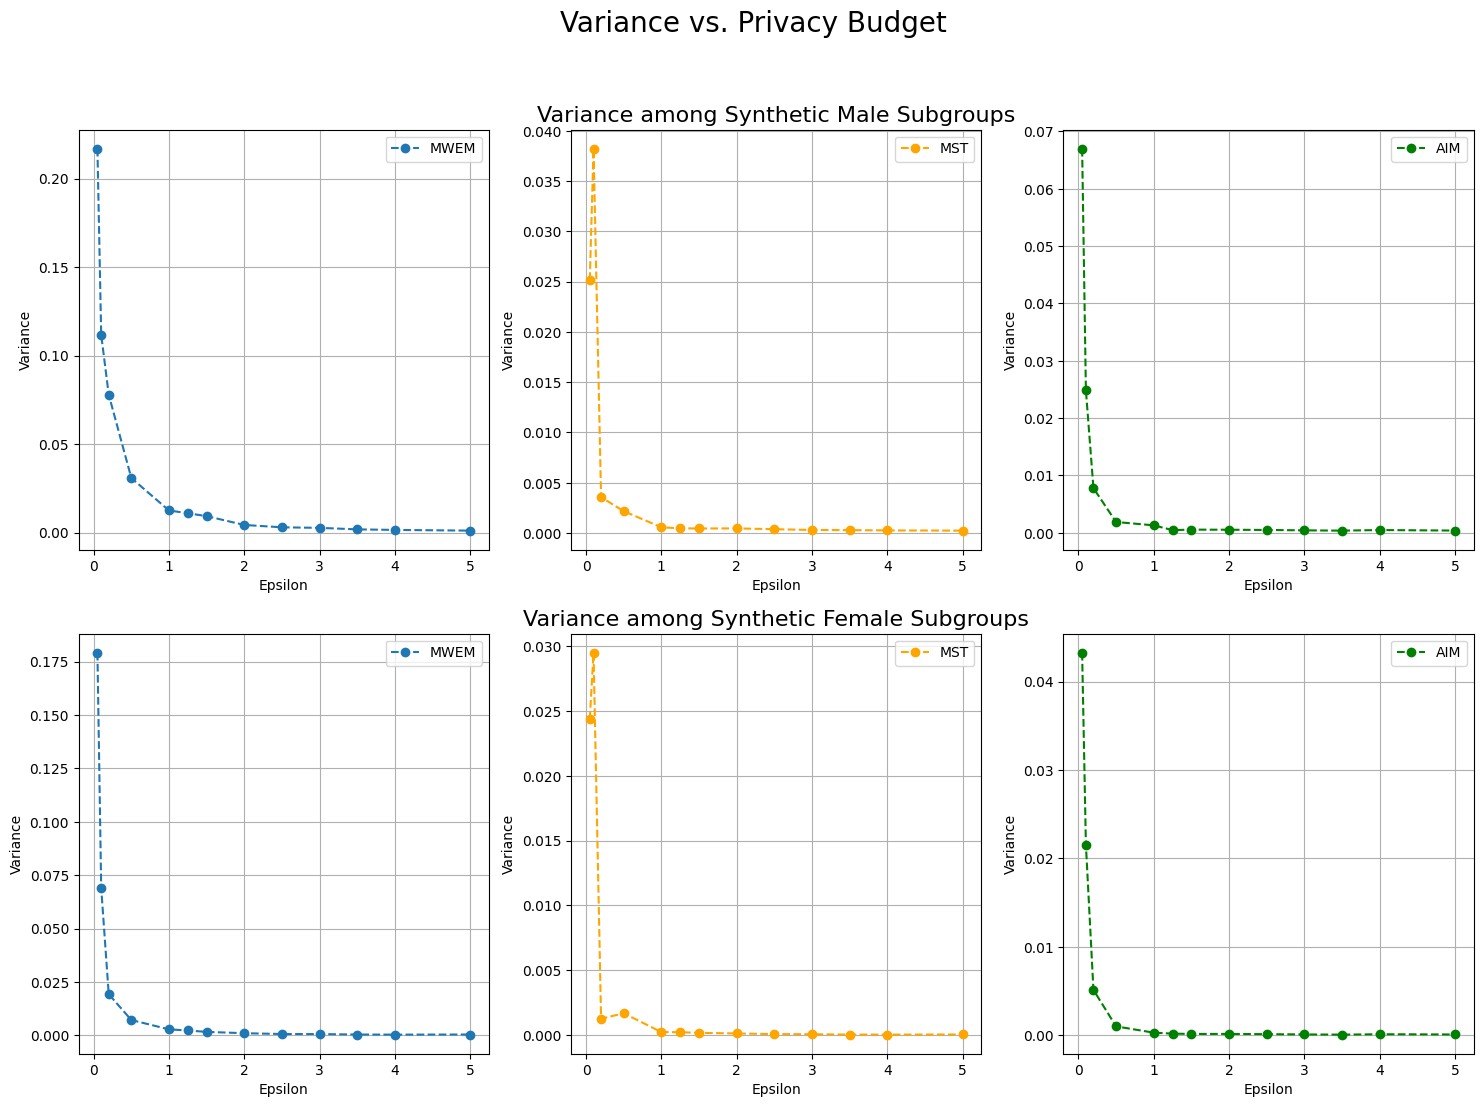

In [143]:
fig = plt.figure(figsize=(18, 12))
# plt.title("Mean Jensen-Shannon Distance over 20 iterations")
#ax = plt.gca()
#fig.supxlabel()
#fig, ax = plt.subplots(1,3)

# print(trial_performances[:,0].shape)


#yerr=[range(1,11),range(1,11)]
#yerr= [ np.percentile(rates[i][0], [75 ,25]) for i in range(len(eps)) ]
#print(yerr)

# print(trial_err[:,0].T)

fig.suptitle("Variance vs. Privacy Budget", fontsize=20)

plt.subplot(2,3,1)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
plt.plot(eps,trial_performances_2_m[:,0], 'o', linestyle='dashed', label='MWEM')
# plt.errorbar(eps,trial_performances_2_m[:,0], yerr=trial_err_m[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend()

plt.subplot(2,3,2)

ax = plt.gca()
ax.grid()
ax.set_title('Variance among Synthetic Male Subgroups', fontsize=16, loc='center')
#ax.set_yscale('log')
plt.plot(eps,trial_performances_2_m[:,1], 'o', linestyle='dashed',color='orange', label='MST')
# plt.errorbar(eps,trial_performances_2_m[:,1], yerr=trial_err_m[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
plt.legend()

plt.subplot(2,3,3)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
plt.plot(eps,trial_performances_2_m[:,2], 'o', color='g', linestyle='dashed', label='AIM')
# plt.errorbar(eps,trial_performances_2_m[:,2], yerr=trial_err_m[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
plt.legend()

# ;kdas;lskf;ldskfl;sdkf;lksdf


plt.subplot(2,3,4)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
plt.plot(eps,trial_performances_2_f[:,0], 'o', linestyle='dashed', label='MWEM')
# plt.errorbar(eps,trial_performances_2_f[:,0], yerr=trial_err_f[:,0].T, fmt='o', linestyle='dashed', label='MWEM')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
#plt.xticks(eps, eps)
plt.legend()

plt.subplot(2,3,5)

ax = plt.gca()
ax.grid()
ax.set_title('Variance among Synthetic Female Subgroups', fontsize=16, loc='center')
#ax.set_yscale('log')
plt.plot(eps,trial_performances_2_f[:,1], 'o',color='orange', linestyle='dashed', label='MST')
# plt.errorbar(eps,trial_performances_2_f[:,1], yerr=trial_err_f[:,1].T,  fmt='o',linestyle='dashed',color='orange', label='MST')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
plt.legend()

plt.subplot(2,3,6)

ax = plt.gca()
ax.grid()
#ax.set_yscale('log')
plt.plot(eps,trial_performances_2_f[:,2], 'o', color='g', linestyle='dashed', label='AIM')
# plt.errorbar(eps,trial_performances_2_f[:,2], yerr=trial_err_f[:,2].T,  fmt='o',linestyle='dashed', color='g', label='AIM')
plt.ylabel("Variance")
plt.xlabel("Epsilon")
plt.legend()

In [141]:
# for i in range(3):
#   a = np.around(trial_performances.T[i],4)
#   # b = np.around(np.percentile( trial_measures[:,i], [25,75], axis=1 ).T, 4)
#   res = [f"{x}" for x in a]
#   print(pd.DataFrame(res,eps))
# print('***********************************')


for i in range(3):
  a = np.around(trial_performances_2_m.T[i],4)
  res = [f"{x}" for x in a]
  print(pd.DataFrame(res,eps))

print('***********************************')
for i in range(3):
  a = np.around(trial_performances_2_f.T[i],4)
  res = [f"{x}" for x in a]
  print(pd.DataFrame(res,eps))

           0
0.05  0.2168
0.10  0.1117
0.20   0.078
0.50  0.0308
1.00  0.0125
1.25   0.011
1.50  0.0093
2.00  0.0043
2.50   0.003
3.00  0.0027
3.50  0.0019
4.00  0.0016
5.00  0.0012
           0
0.05  0.0252
0.10  0.0382
0.20  0.0036
0.50  0.0022
1.00  0.0006
1.25  0.0005
1.50  0.0005
2.00  0.0005
2.50  0.0004
3.00  0.0003
3.50  0.0003
4.00  0.0003
5.00  0.0002
           0
0.05   0.067
0.10  0.0249
0.20  0.0078
0.50  0.0019
1.00  0.0013
1.25  0.0005
1.50  0.0005
2.00  0.0005
2.50  0.0005
3.00  0.0004
3.50  0.0004
4.00  0.0005
5.00  0.0004
***********************************
           0
0.05  0.1791
0.10   0.069
0.20  0.0193
0.50  0.0072
1.00  0.0028
1.25  0.0023
1.50  0.0016
2.00   0.001
2.50  0.0006
3.00  0.0006
3.50  0.0004
4.00  0.0003
5.00  0.0004
           0
0.05  0.0244
0.10  0.0295
0.20  0.0013
0.50  0.0017
1.00  0.0002
1.25  0.0002
1.50  0.0002
2.00  0.0001
2.50  0.0001
3.00  0.0001
3.50     0.0
4.00     0.0
5.00  0.0001
           0
0.05  0.0433
0.10  0.0215
0.20  0.0051
0.